In [1]:
pip install huggingface_hub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /home/verokul/SegFormer/env_sf_py311/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
Поскольку мы делаем классификацию авторства текстов на PyTorch, то понадобится только pytorch_model.bin + токенизатор.

скачаем  локально

In [1]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="DeepPavlov/rubert-base-cased",
    local_dir="./rubert",
    ignore_patterns=["*.msgpack", "*.safetensors", "*.h5", "*.onnx"])

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

'/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/rubert'

In [3]:
# Загрузим модель локально
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/rubert/")
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert", num_labels=4
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./rubert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Выполним загрузку и предобработку данных
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer


CSV_PATH = "/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/dataset.csv"

# Загрузка
df = pd.read_csv(CSV_PATH)

print(df.head())
print(df.info())

# Убедимся, что тексты — строки и нет пропусков
df = df.dropna(subset=["text", "author"])
df["text"] = df["text"].astype(str)

# Кодируем авторов в числа
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["author"])

print("Распределение по авторам:")
print(df["author"].value_counts())
print("\nМетки:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

   author                                               text
0  Есенин  Вот уж вечер.  Роса\nБлестит на крапиве.\nЯ ст...
1  Есенин  Хорошо и тепло,\nКак зимой у печки.\nИ березы ...
2  Есенин  Поет зима - аукает,\nМохнатый лес баюкает\nСто...
3  Есенин  Там, где капустные грядки\nКрасной водой полив...
4  Есенин  А по двору метелица\nКовром шелковым стелется,...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  420 non-null    object
 1   text    420 non-null    object
dtypes: object(2)
memory usage: 6.7+ KB
None
Распределение по авторам:
author
Бунин         108
Цветаева      108
Есенин        103
Маяковский    101
Name: count, dtype: int64

Метки: {'Бунин': np.int64(0), 'Есенин': np.int64(1), 'Маяковский': np.int64(2), 'Цветаева': np.int64(3)}


In [5]:
# Разделим данные на train / val / test (стратифицированно)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

print(f"\nРазмеры:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Размеры:
Train: 294 | Val: 63 | Test: 63


In [6]:
# Cоздадим датасет для BERT
class PoemDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
# Определим функцию для обучения модели
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=5, learning_rate=2e-5, freeze_bert=False):
    if freeze_bert:
        for param in model.bert.parameters():
            param.requires_grad = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Тренировка
        model.train()
        total_loss, total_acc = 0, 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_acc += accuracy_score(labels.cpu(), preds.cpu())

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)

        # Валидация
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                val_acc += accuracy_score(labels.cpu(), preds.cpu())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(avg_train_acc)
        val_accs.append(avg_val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}\n")

    return train_losses, val_losses, train_accs, val_accs

In [8]:
# Обучение модели 1a и 1b

MODEL_PATH = "/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/rubert"

# Подготовка датасетов
train_dataset = PoemDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = PoemDataset(val_df["text"].tolist(), val_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Модель 1a // замороженный BERT 
print("Обучение Модели 1a (замороженный BERT)=")
model_1a = BertForSequenceClassification.from_pretrained(
    MODEL_PATH, num_labels=4
)
train_losses_1a, val_losses_1a, train_accs_1a, val_accs_1a = train_model(
    model_1a, train_loader, val_loader, epochs=10, learning_rate=1e-3, freeze_bert=True
)

# Модель 1b // fine-tuning
print("Обучение Модели 1b (fine-tuning)")
model_1b = BertForSequenceClassification.from_pretrained(
    MODEL_PATH, num_labels=4
)
train_losses_1b, val_losses_1b, train_accs_1b, val_accs_1b = train_model(
    model_1b, train_loader, val_loader, epochs=5, learning_rate=2e-5, freeze_bert=False
)

Обучение Модели 1a (замороженный BERT)=


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/rubert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
  Train Loss: 1.3483, Acc: 0.2961
  Val   Loss: 1.2833, Acc: 0.3156

Epoch 2/10
  Train Loss: 1.2861, Acc: 0.3542
  Val   Loss: 1.2431, Acc: 0.4115

Epoch 3/10
  Train Loss: 1.2367, Acc: 0.4189
  Val   Loss: 1.2025, Acc: 0.3667

Epoch 4/10
  Train Loss: 1.1990, Acc: 0.4079
  Val   Loss: 1.1599, Acc: 0.4906

Epoch 5/10
  Train Loss: 1.1658, Acc: 0.5000
  Val   Loss: 1.1267, Acc: 0.5375

Epoch 6/10
  Train Loss: 1.1282, Acc: 0.5362
  Val   Loss: 1.0997, Acc: 0.6365

Epoch 7/10
  Train Loss: 1.1179, Acc: 0.5581
  Val   Loss: 1.0886, Acc: 0.5563

Epoch 8/10
  Train Loss: 1.0859, Acc: 0.5910
  Val   Loss: 1.0691, Acc: 0.5885

Epoch 9/10
  Train Loss: 1.1142, Acc: 0.4978
  Val   Loss: 1.0470, Acc: 0.6198

Epoch 10/10
  Train Loss: 1.1137, Acc: 0.5055
  Val   Loss: 1.0416, Acc: 0.5396

Обучение Модели 1b (fine-tuning)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/rubert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
  Train Loss: 1.2283, Acc: 0.4046
  Val   Loss: 1.0610, Acc: 0.5906

Epoch 2/5
  Train Loss: 0.8882, Acc: 0.7116
  Val   Loss: 0.8008, Acc: 0.7771

Epoch 3/5
  Train Loss: 0.6193, Acc: 0.8553
  Val   Loss: 0.3901, Acc: 0.9219

Epoch 4/5
  Train Loss: 0.2516, Acc: 0.9638
  Val   Loss: 0.1449, Acc: 0.9688

Epoch 5/5
  Train Loss: 0.0781, Acc: 0.9901
  Val   Loss: 0.0813, Acc: 0.9677



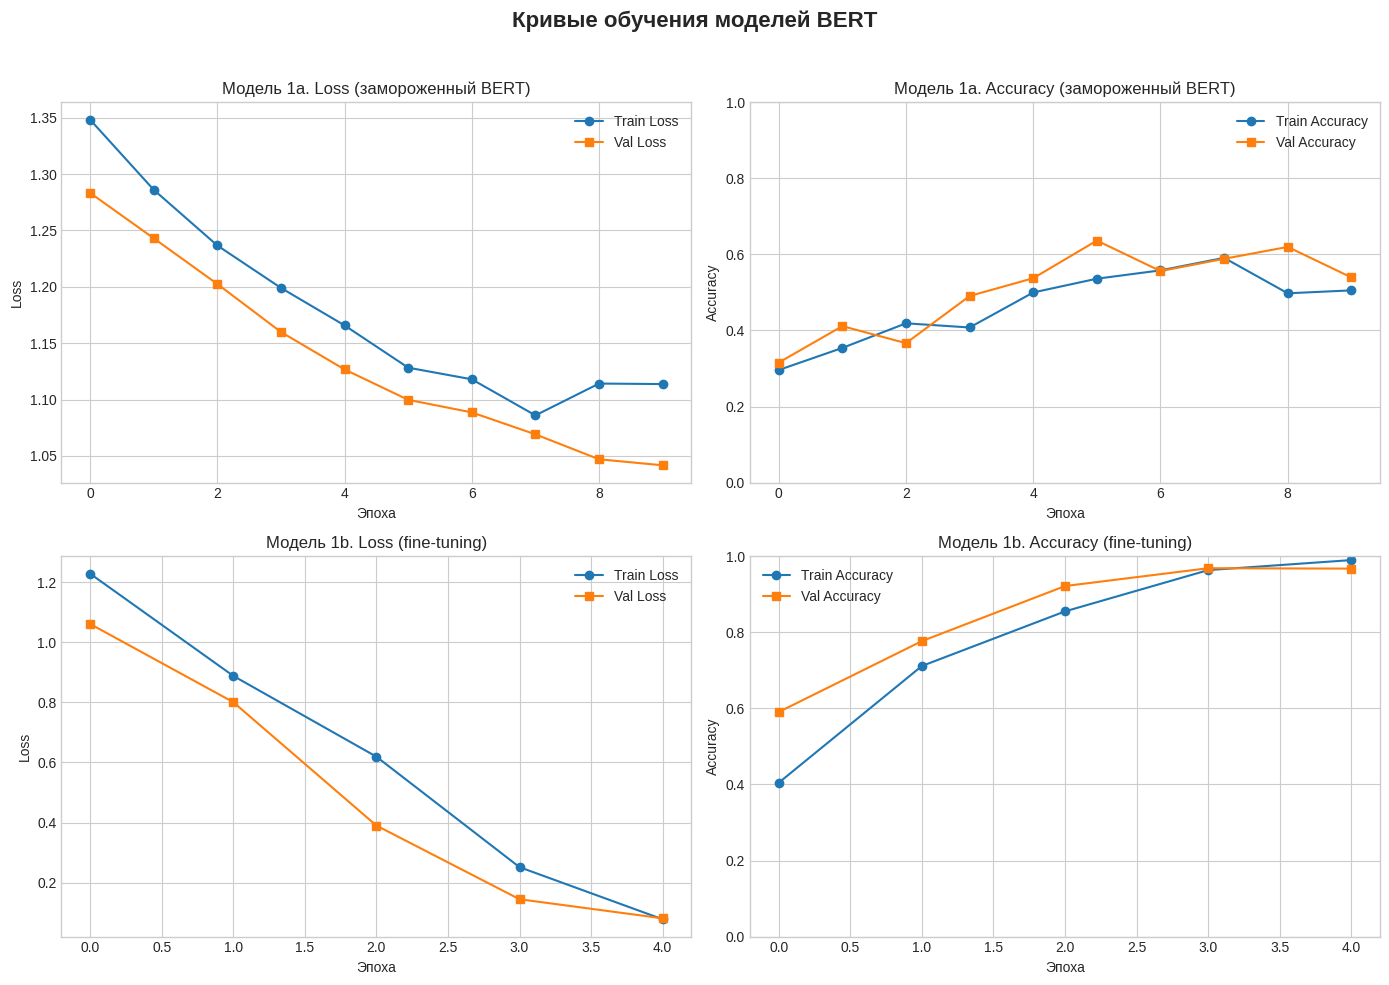

In [9]:
# Построим графики обучения
import matplotlib.pyplot as plt

# Настройка стиля
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Кривые обучения моделей BERT', fontsize=16, fontweight='bold')

# Модель 1a. Замороженный BERT
axes[0, 0].plot(train_losses_1a, label='Train Loss', marker='o')
axes[0, 0].plot(val_losses_1a, label='Val Loss', marker='s')
axes[0, 0].set_title('Модель 1a. Loss (замороженный BERT)')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(train_accs_1a, label='Train Accuracy', marker='o')
axes[0, 1].plot(val_accs_1a, label='Val Accuracy', marker='s')
axes[0, 1].set_title('Модель 1a. Accuracy (замороженный BERT)')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Модель 1b. Fine-tuned BERT
axes[1, 0].plot(train_losses_1b, label='Train Loss', marker='o')
axes[1, 0].plot(val_losses_1b, label='Val Loss', marker='s')
axes[1, 0].set_title('Модель 1b. Loss (fine-tuning)')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(train_accs_1b, label='Train Accuracy', marker='o')
axes[1, 1].plot(val_accs_1b, label='Val Accuracy', marker='s')
axes[1, 1].set_title('Модель 1b. Accuracy (fine-tuning)')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("bert_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import torch
from sklearn.metrics import accuracy_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Оценим на тестовой выборке
test_dataset = PoemDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_1b.to(device)  # убедитесь, что модель на правильном устройстве
model_1b.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)  

        outputs = model_1b(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # Переводим на CPU и в numpy для sklearn
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Метрики
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")  # ← исправлено форматирование

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

Test Accuracy: 0.9683

Classification Report:
              precision    recall  f1-score   support

       Бунин       0.89      1.00      0.94        17
      Есенин       1.00      0.87      0.93        15
  Маяковский       1.00      1.00      1.00        15
    Цветаева       1.00      1.00      1.00        16

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



## Обучение стека LSTM и двунаправленной LSTM (BiLSTM) для классификации авторства.




LSTM
Epoch 1/50 | Train Loss: 1.3665, Acc: 0.2789 | Val Loss: 1.3343, Acc: 0.2381
Epoch 2/50 | Train Loss: 1.3234, Acc: 0.3231 | Val Loss: 1.2994, Acc: 0.2222
Epoch 3/50 | Train Loss: 1.2911, Acc: 0.3946 | Val Loss: 1.2698, Acc: 0.2857
Epoch 4/50 | Train Loss: 1.2910, Acc: 0.3571 | Val Loss: 1.2502, Acc: 0.3016
Epoch 5/50 | Train Loss: 1.2681, Acc: 0.3639 | Val Loss: 1.2256, Acc: 0.4127
Epoch 6/50 | Train Loss: 1.2133, Acc: 0.4354 | Val Loss: 1.2049, Acc: 0.4127
Epoch 7/50 | Train Loss: 1.1931, Acc: 0.5068 | Val Loss: 1.1795, Acc: 0.4603
Epoch 8/50 | Train Loss: 1.1689, Acc: 0.4762 | Val Loss: 1.1482, Acc: 0.4286
Epoch 9/50 | Train Loss: 1.1427, Acc: 0.5272 | Val Loss: 1.1156, Acc: 0.5079
Epoch 10/50 | Train Loss: 1.1167, Acc: 0.5442 | Val Loss: 1.0732, Acc: 0.5397
Epoch 11/50 | Train Loss: 1.0746, Acc: 0.5918 | Val Loss: 1.0185, Acc: 0.6349
Epoch 12/50 | Train Loss: 1.0449, Acc: 0.6088 | Val Loss: 0.9433, Acc: 0.6190
Epoch 13/50 | Train Loss: 1.0228, Acc: 0.6054 | Val Loss: 0.8764, A

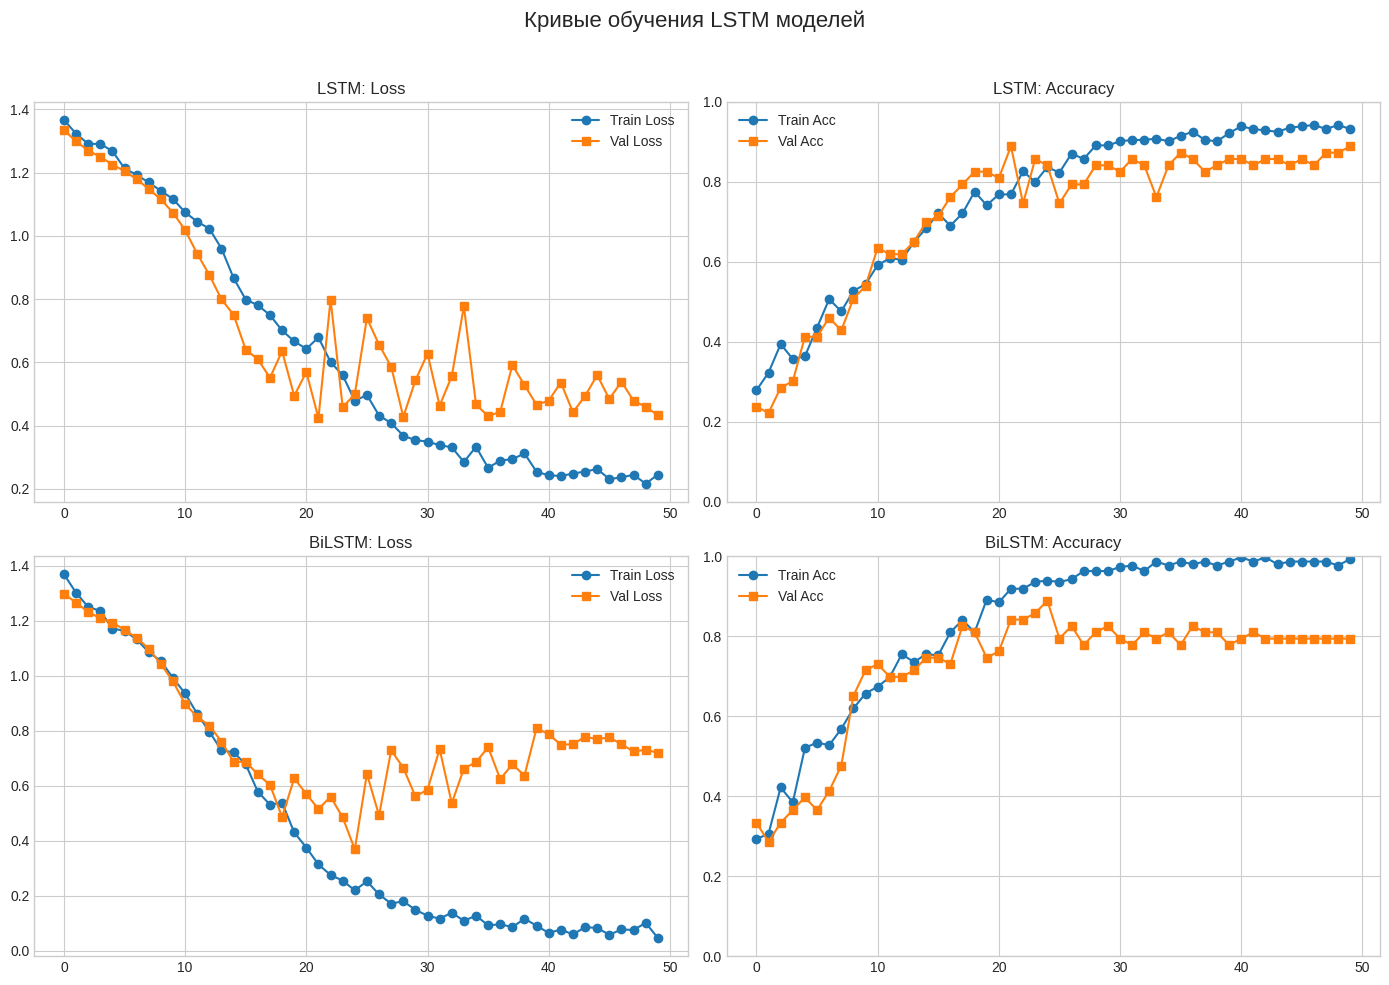


LSTM
              precision    recall  f1-score   support

       Бунин     0.9091    0.5882    0.7143        17
      Есенин     0.7000    0.9333    0.8000        15
  Маяковский     0.5556    0.6667    0.6061        15
    Цветаева     0.9286    0.8125    0.8667        16

    accuracy                         0.7460        63
   macro avg     0.7733    0.7502    0.7468        63
weighted avg     0.7801    0.7460    0.7476        63



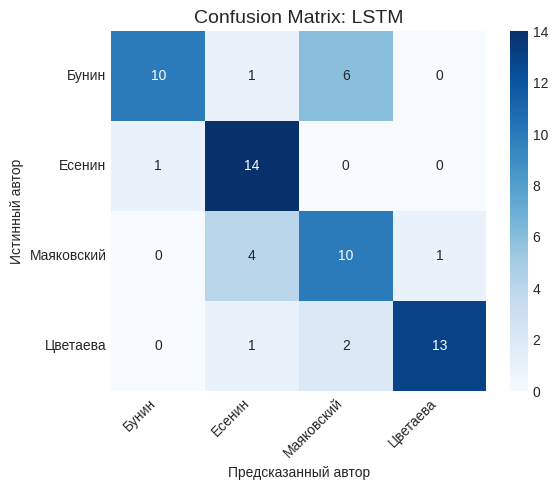


BiLSTM
              precision    recall  f1-score   support

       Бунин     1.0000    0.7647    0.8667        17
      Есенин     0.7368    0.9333    0.8235        15
  Маяковский     0.6000    0.6000    0.6000        15
    Цветаева     0.8750    0.8750    0.8750        16

    accuracy                         0.7937        63
   macro avg     0.8030    0.7933    0.7913        63
weighted avg     0.8104    0.7937    0.7950        63



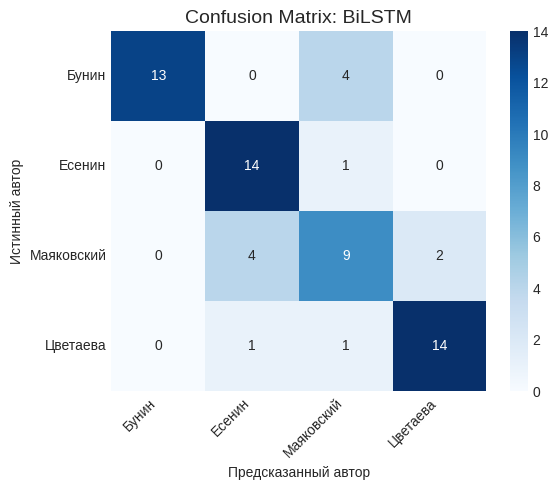

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# Загрузка данных

CSV_PATH = "/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_07/dataset.csv"
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["text", "author"])
df["text"] = df["text"].astype(str)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["author"])

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# -------------------------------------------------
# 2. Словарь (УМЕНЬШАЕМ размер — меньше переобучение)
# -------------------------------------------------
def simple_tokenize(text):
    return text.lower().split()

all_tokens = []
for text in df["text"]:
    all_tokens.extend(simple_tokenize(str(text)))

from collections import Counter
VOCAB_SIZE = 7000  # БЫЛО 20000 — слишком много для 420 текстов
counter = Counter(all_tokens)
most_common = counter.most_common(VOCAB_SIZE - 2)
word_to_idx = {"<PAD>": 0, "<UNK>": 1}
word_to_idx.update({word: idx + 2 for idx, (word, _) in enumerate(most_common)})

# -------------------------------------------------
# 3. Dataset
# -------------------------------------------------
class LSTMDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len=64):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = simple_tokenize(str(self.texts[idx]))
        indices = [self.word_to_idx.get(tok, 1) for tok in tokens]
        
        if len(indices) > self.max_len:
            indices = indices[-self.max_len:]
        else:
            indices = [0] * (self.max_len - len(indices)) + indices
            
        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# -------------------------------------------------
# 4. Архитектуры 
# -------------------------------------------------
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_layers=1, num_classes=4, dropout=0.5):  # УМЕНЬШИМ размеры
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers,
            batch_first=True,  bidirectional=False  # dropout только снаружи
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # ДОБАВИЛИ dropout на эмбеддинги
        output, _ = self.lstm(x)
        features = output[:, -1, :]
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_layers=1, num_classes=4, dropout=0.4):  # УМЕНЬШИЛИ
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers,
            batch_first=True, bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, _ = self.lstm(x)
        features = output[:, -1, :]
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits

# -------------------------------------------------
# 5. Обучение с weight decay и early stopping
# -------------------------------------------------
def train_lstm_model(model, train_loader, val_loader, epochs=50, lr=5e-4, weight_decay=0.005, max_len=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0
    patience_counter = 0
    PATIENCE = 7

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())

        val_acc = correct_val / total_val
        val_loss = val_loss / len(val_loader)

        scheduler.step(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# -------------------------------------------------
# 6. Датасеты и обучение
# -------------------------------------------------
MAX_LEN = 64  # БЫЛО 128
BATCH_SIZE = 16  # БЫЛО 32 — меньше батч лучше для малых данных

train_lstm_dataset = LSTMDataset(train_df["text"].tolist(), train_df["label"].tolist(), word_to_idx, MAX_LEN)
val_lstm_dataset = LSTMDataset(val_df["text"].tolist(), val_df["label"].tolist(), word_to_idx, MAX_LEN)
test_lstm_dataset = LSTMDataset(test_df["text"].tolist(), test_df["label"].tolist(), word_to_idx, MAX_LEN)

train_lstm_loader = DataLoader(train_lstm_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_lstm_loader = DataLoader(val_lstm_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_lstm_loader = DataLoader(test_lstm_dataset, batch_size=BATCH_SIZE, shuffle=False)

vocab_size = len(word_to_idx)

# Обучение
print("\nLSTM")
lstm = LSTM(vocab_size=vocab_size, num_classes=4)
train_losses_lstm, val_losses_lstm, train_accs_lstm, val_accs_lstm = train_lstm_model(
    lstm, train_lstm_loader, val_lstm_loader, epochs=50, lr=5e-4)

print("\n BiLSTM")
bilstm = BiLSTM(vocab_size=vocab_size, num_classes=4)
train_losses_bilstm, val_losses_bilstm, train_accs_bilstm, val_accs_bilstm = train_lstm_model(
    bilstm, train_lstm_loader, val_lstm_loader, epochs=50, lr=5e-4)

# -------------------------------------------------
# 9. Оценка на тестовой выборке
# -------------------------------------------------
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Оценка
labels_lstm, preds_lstm = evaluate_model(lstm, test_lstm_loader)
labels_bilstm, preds_bilstm = evaluate_model(bilstm, test_lstm_loader)

print("\nТестовые результаты")
print(f"LSTM Test Accuracy: {accuracy_score(labels_lstm, preds_lstm):.4f}")
print(f"BiLSTM Test Accuracy: {accuracy_score(labels_bilstm, preds_bilstm):.4f}")

# -------------------------------------------------
# 10. Графики
# -------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Кривые обучения LSTM моделей', fontsize=16)

# LSTM
axes[0, 0].plot(train_losses_lstm, label='Train Loss', marker='o')
axes[0, 0].plot(val_losses_lstm, label='Val Loss', marker='s')
axes[0, 0].set_title('LSTM: Loss')
axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(train_accs_lstm, label='Train Acc', marker='o')
axes[0, 1].plot(val_accs_lstm, label='Val Acc', marker='s')
axes[0, 1].set_title('LSTM: Accuracy')
axes[0, 1].set_ylim(0, 1); axes[0, 1].legend(); axes[0, 1].grid(True)

# BiLSTM
axes[1, 0].plot(train_losses_bilstm, label='Train Loss', marker='o')
axes[1, 0].plot(val_losses_bilstm, label='Val Loss', marker='s')
axes[1, 0].set_title('BiLSTM: Loss')
axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(train_accs_bilstm, label='Train Acc', marker='o')
axes[1, 1].plot(val_accs_bilstm, label='Val Acc', marker='s')
axes[1, 1].set_title('BiLSTM: Accuracy')
axes[1, 1].set_ylim(0, 1); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("lstm_curves.png", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 11. Classification Report и Confusion Matrix (Heatmap)
# -------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_cm_and_report(labels, preds, model_name, classes, save_prefix=None):
    # Classification Report
    report = classification_report(labels, preds, target_names=classes, digits=4)
    print(f"\n{model_name}")
    print(report)
    
    if save_prefix:
        with open(f"{save_prefix}_report.txt", "w") as f:
            f.write(report)
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar=True
    )
    plt.title(f'Confusion Matrix: {model_name}', fontsize=14)
    plt.ylabel('Истинный автор')
    plt.xlabel('Предсказанный автор')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f"{save_prefix}_cm.png", dpi=300, bbox_inches='tight')
    plt.show()

# Получаем результаты (если ещё не получены)
labels_lstm, preds_lstm = evaluate_model(lstm, test_lstm_loader)
labels_bilstm, preds_bilstm = evaluate_model(bilstm, test_lstm_loader)

# Визуализация для LSTM
plot_cm_and_report(
    labels_lstm, preds_lstm,
    "LSTM",
    label_encoder.classes_,
    save_prefix="_lstm"
)

# Визуализация для BiLSTM
plot_cm_and_report(
    labels_bilstm, preds_bilstm,
    "BiLSTM",
    label_encoder.classes_,
    save_prefix="bilstm"
)